In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np

cores = 4

In [2]:
tweets_with_originals = pd.read_csv('tweets_with_originals.csv', parse_dates = ['tweet_created'])

In [3]:
tweets_with_originals['text_clean'] = tweets_with_originals.text_clean.str.replace(r'@(\w+)([\s.,:;!])?', r'\1 ') # remove @s in @mentions

In [4]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string
#stopwords = stopwords.union(set([i for i in string.punctuation])) # remove punctuation
#stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

In [5]:
tweets_with_originals.loc[55].text_clean

"VirginAmerica hi! i'm so excited about your $99 LGA->DAL deal- but i've been trying 2 book since last week & the page never loads. thx!"

# TF-IDF to identify additional stopwords 

Using TF-IDF, we'll look for additional stopwords 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10)
tweet_input = tweets_with_originals.text_clean
# maybe try to take out numbers, prices 
tweet_input=tweet_input.str.replace(r" (\d|\W)+","") # remove digits, nonword things
T = tfidf_vectorizer.fit_transform(tweet_input) # these are our features

In [7]:
idf_df = pd.DataFrame(index = tfidf_vectorizer.get_feature_names())
idf_df['idf_vals']= tfidf_vectorizer.idf_
idf_df.describe()

,idf_vals
count,1628.000000
mean,7.120723
std,0.958025
min,2.421465
25%,6.609403
50%,7.360819
75%,7.871644
max,8.181799


The minimum inverse document frequency is not so low. For our first pass I won't add any stopwords based on IDF values. 

We can use this array of tfidf vectors as input features... for testing purposes we'll also allow 2-grams and 3-grams to see if this improves the result. 

In [8]:
tf2_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,2))
tf3_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,3))
T_2 = tf2_vectorizer.fit_transform(tweet_input) 
T_3 = tf3_vectorizer.fit_transform(tweet_input)

tfidf_input_mats = [T, T_2, T_3]

# Word2Vec Model 

First we'll train a word2vec model on our tweets and see what sorts of words are grouped together. 

In [9]:
from nltk.tokenize.casual import TweetTokenizer
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
cores = 4 # depends on how many cores you have...

tokenizer = TweetTokenizer(preserve_case=False)
tokenized_input = [tokenizer.tokenize(tweet) for tweet in tweet_input.values]
tokenized_input = [[word for word in tweet if word not in string.punctuation] for tweet in tokenized_input]
model = Word2Vec(tokenized_input, window=5, min_count=10, workers=cores) # build vocabulary

model.train(tokenized_input, total_examples=len(tokenized_input), epochs=10)
model.save('airlinetweet_word2vec.model')

The results look ok, airlines are associated with other airlines...

In [10]:
model.wv.most_similar('united')

/conda/envs/nlp/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('jetblue', 0.8662815093994141),
 ('americanair', 0.8628705739974976),
 ('southwestair', 0.8120953440666199),
 ('usairways', 0.7812957763671875),
 ('virginamerica', 0.6427493095397949),
 ('that', 0.45561307668685913),
 ('mind', 0.4543249309062958),
 ('but', 0.45242786407470703),
 ('guess', 0.4319174885749817),
 ('however', 0.4314931035041809)]

In [11]:
model.wv.most_similar('usairways')

[('americanair', 0.8087992072105408),
 ('united', 0.7812957763671875),
 ('southwestair', 0.7618030309677124),
 ('jetblue', 0.739116907119751),
 ('virginamerica', 0.47068217396736145),
 ('guess', 0.43932756781578064),
 ('happening', 0.4298640489578247),
 ('mind', 0.42269501090049744),
 ('ridiculous', 0.41210249066352844),
 ('already', 0.4079624116420746)]

And TSA with security check type things

In [12]:
model.wv.most_similar('tsa')

[('pre', 0.8296579718589783),
 ('file', 0.7714195251464844),
 ('correct', 0.7350829839706421),
 ('fare', 0.7199697494506836),
 ('name', 0.7141523957252502),
 ('receipt', 0.7087810635566711),
 ('res', 0.697322428226471),
 ('guarantee', 0.6813904047012329),
 ('uk', 0.6726496815681458),
 ('listed', 0.6676491498947144)]

## Doc2Vec Model

Doc2Vec learns "document" vectors instead of word vectors. We view each tweet as a document

In [13]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
sentiment_tweets_docs = [TaggedDocument(tokenized_input[i], [str(tweets_with_originals.tweet_id.iloc[i])]) for i in range(tweet_input.shape[0])]

In [14]:
model_doc2vec = Doc2Vec(dm=1, vector_size=300, hs=1, window=5,
                        min_count=10, sample=0, epochs=20, alpha = .4, 
                        workers=cores, dbow_words = 1)
model_doc2vec.build_vocab(sentiment_tweets_docs)
model_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_doc2vec.save('airlinetweet_doc2vec.model')

In [15]:
model_doc2vec.wv.most_similar('late')

[('track', 0.7873563170433044),
 ('phl', 0.7872782349586487),
 ('whatever', 0.787070631980896),
 ('experienced', 0.7815811038017273),
 ('schedule', 0.7807751297950745),
 ('mileage', 0.776772141456604),
 ('row', 0.7736649513244629),
 ('being', 0.7597764134407043),
 ('we', 0.7578635811805725),
 ('concern', 0.7534886598587036)]

In [16]:
model_doc2vec.wv.most_similar('delay')

[('joke', 0.8867878317832947),
 ('web', 0.8811459541320801),
 ('funeral', 0.8713045120239258),
 ('purchase', 0.8697883486747742),
 ('stuck', 0.8601381778717041),
 ('conference', 0.8441726565361023),
 ('ashamed', 0.8430130481719971),
 ('yall', 0.8419787883758545),
 ('arrived', 0.8355956077575684),
 ('full', 0.833648145198822)]

In [17]:
model_doc2vec.wv.most_similar('tsa')

[('because', 0.9073868989944458),
 ('return', 0.8793728351593018),
 ('lie', 0.8744453191757202),
 ('pick', 0.8634284734725952),
 ('expensive', 0.8632164001464844),
 ('dealing', 0.8628031611442566),
 ('death', 0.8622838258743286),
 ('plus', 0.8597457408905029),
 ('account', 0.851006031036377),
 ('view', 0.8483704328536987)]

In [18]:
model_doc2vec.docvecs.most_similar('570085644015419393')

[('569716449704587265', 0.8207513093948364),
 ('569769643864408064', 0.8193365335464478),
 ('569724918016839681', 0.8040217757225037),
 ('569623156337586177', 0.7942930459976196),
 ('568668179158806529', 0.772573709487915),
 ('569341439148236800', 0.7655583620071411),
 ('569917692758630400', 0.7649120092391968),
 ('568925054089629696', 0.7628576755523682),
 ('568042975856619520', 0.7626336812973022),
 ('569915529496027136', 0.757616400718689)]

The following tweets are quite similar according to the model: 

In [19]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570085644015419393]['text_clean'].values

array(["USAirways  A few years ago I lost over 50,00 miles bc I was physically unable to fly during the period.  I submitted a doctor's note."],
      dtype=object)

In [20]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570274362936266752]['text_clean'].values

array(['SouthwestAir Teyana Taylor Performing #MedusaFridays 2[.] 27 Free Till11   #TheMenOfBusiness'],
      dtype=object)

In [21]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 569734884396302338]['text_clean'].values

array(['USAirways #usairways lost a passenger today for not upholding their promise of excellent customer service!!'],
      dtype=object)

In [22]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570277054635057153]['text_clean'].values

array(['jetblue having trouble signing in to TrueBlue today, despite right credentials. getting "We are not able to sign you in" msg.'],
      dtype=object)

They are at least all negative sentiment tweets, so hopefully we're heading in the right direction. 

### TODO: different models with different hyperparameters, methods (DBOW vs not etc) as a list, test train split on all of these to test model (better accuracy -> better model (ish) 

# Sentiment Analysis

The sentiments in our dataset are highly imbalanced: 

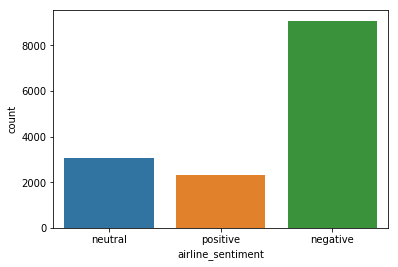

In [15]:
_ = sns.countplot(x = 'airline_sentiment', data = tweets_with_originals)

There are a lot of strategies we could try to rebalance the dataset. The easiest would be oversampling the neutral/positive sentiment tweets. 

In [61]:
from sklearn.model_selection import train_test_split
#TODO: finish this

def doc2vec_train_test_split(trained_model, doc_ids, target_vec, test_size=.3):
    '''
    returns test train using paragraph vectors for tweets 
    (lookup based on tweet_id)
    
    '''
    train_ids, test_ids = train_test_split(doc_ids, test_size = test_size)
    train_docvec_idx = trained_model.vocabulary.indexed_doctags(train_ids, trained_model.docvecs)
    test_docvec_idx = trained_model.vocabulary.indexed_doctags(test_ids, trained_model.docvecs)

    X_train = np.array([trained_model.docvecs[idx] for idx in train_docvec_idx])
    X_test = np.array([trained_model.docvecs[idx] for idx in test_docvec_idx])

    y_train = target_vec.iloc[train_docvec_idx]
    y_test = target_vec.iloc[test_docvec_idx]
    return X_train, X_test, y_train, y_test

In [65]:
# test split with oversampling ... try SMOTE 
from imblearn.over_sampling import SMOTE

y = tweets_with_originals.airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})

# test_train split for TFIDF outputs 
tfidf_learning_inputs = []
for M in tfidf_input_mats:
    T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3)
    sm = SMOTE() # smarter upsampling 
    T_train_sm, y_train_sm = sm.fit_sample(T_train, y_train.ravel())
    tfidf_learning_inputs.append([T_train_sm, T_test, y_train_sm, y_test])

In [ ]:
# test_train_split for Doc2Vec outputs
#train

## Method 1: TF-IDF output